In [18]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import noisereduce
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
#import torchvision
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from matplotlib import rcParams

In [19]:
lab_df = pd.read_csv('Summary_Emo_Eval.csv')

lab_dic = {}
for ind, row in lab_df.iterrows():
    label = row['emotion']
    if label == 'xxx':
        lab_dic[row['wav_filename']] = 'oth' # other
    elif label == 'exc': # excited
        lab_dic[row['wav_filename']] = 'hap' # happy
    else:
        lab_dic[row['wav_filename']] = label

In [20]:
dataset_dir = 'IEMOCAP/'

Y = []
mel_list = []

for session in [2]:#range(1,6)
    wav_sess_dir = dataset_dir + f'Session{session}/sentences/wav/'
    dialog_names = os.listdir(wav_sess_dir)
    for dialog in dialog_names:
        if dialog.startswith('.'):
            continue
        wav_dialog_dir = wav_sess_dir+dialog+'/'
        sentences_names = os.listdir(wav_dialog_dir)
        for sentence in sentences_names:
            if sentence.startswith('.'):
                continue
            if not sentence.endswith('wav'):
                continue
            label = [lab_dic[sentence[:-4]]]
            if not label[0] in ['ang','hap','sad','neu']:
                continue
            wav_sentence_path = wav_dialog_dir+sentence
            waveform, sr = librosa.load(wav_sentence_path, sr=None)
            melspec = librosa.feature.melspectrogram(y=waveform, sr=sr)
            mel = np.mean(melspec.T, axis=0)
            Y.append(label)
            mel_list.append(mel.tolist())

In [21]:
X = mel_list

X_all = np.array(X)
enc = OneHotEncoder()
enc.fit([['ang'],['hap'],['sad'],['neu']])
Y_all = enc.transform(Y).toarray()

Xtrain, Xvaltest, Ytrain, Yvaltest = train_test_split(X_all, Y_all, test_size=0.2, random_state=42, shuffle=True)
Xval, Xtest, Yval, Ytest = train_test_split(Xvaltest, Yvaltest, test_size=0.5, random_state=42, shuffle=True)

Xtrain_c = np.expand_dims(Xtrain, axis=1)
Xval_c = np.expand_dims(Xval, axis=1)
Xtest_c = np.expand_dims(Xtest, axis=1)

In [22]:
class NNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 256, 5, padding=2)
        self.bn1 = nn.BatchNorm1d(256)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(256, 128, 5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.drop = nn.Dropout(0.1)
        self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(128, 128, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(2)
        self.conv4 = nn.Conv1d(128, 128, 5, padding=2)
        self.conv5 = nn.Conv1d(128, 128, 5, padding=2)
        self.bn4 = nn.BatchNorm1d(128)
        self.conv6 = nn.Conv1d(128, 128, 5, padding=2)
        self.fc = nn.Linear(2048, 4)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.drop(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.softmax(x)
        return x

net = NNModel()

In [23]:
Xtrain_ts  = torch.Tensor(Xtrain_c)
Ytrain_ts  = torch.Tensor(Ytrain)

Xval_ts = torch.Tensor(Xval_c)
Yval_ts = torch.Tensor(Yval)

Xtest_ts = torch.Tensor(Xtest_c)
Ytest_ts = torch.Tensor(Ytest)

batch_size = 4

train_set = torch.utils.data.TensorDataset(Xtrain_ts,Ytrain_ts)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=False,num_workers=2)

val_set = torch.utils.data.TensorDataset(Xval_ts,Yval_ts)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=batch_size,shuffle=False,num_workers=2)

test_set = torch.utils.data.TensorDataset(Xtest_ts,Ytest_ts)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=batch_size,shuffle=False,num_workers=2)

In [24]:
def Tlabels(a):
    L1=[]
    for x in a:
        L1.append(x)
    return L1


def Plabels(b):
    L2=[]
    for x in b:
        L2.append(x)
    return L2

def conf_mat(cm,L1,L2):
    if len(L2)<1:
        return cm
    for i in range(len(L1)):
        if L2[i]==L1[i]:
            cm[L1[i]][L1[i]]=cm[L1[i]][L1[i]]+1
        else:
            cm[L2[i]][L1[i]]=cm[L2[i]][L1[i]]+1
    return cm
            
def cmplot(cm):
    classes = ['ang','hap','sad','neu']
    confusion_matrix = np.array(cm,dtype=np.int)
    proportion=[]
    for i in confusion_matrix:
        for j in i:
            temp=j/(np.sum(i))
            proportion.append(temp)
    pshow=[]
    for i in proportion:
        pt="%.2f%%" % (i * 100)
        pshow.append(pt)
    proportion=np.array(proportion).reshape(4,4)  
    pshow=np.array(pshow).reshape(4,4)
    #print(pshow)
    config = {
        "font.family":'Times New Roman',  
    }
    rcParams.update(config)
    plt.imshow(proportion, interpolation='nearest', cmap=plt.cm.Blues) 
    plt.title('confusion_matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,fontsize=12)
    plt.yticks(tick_marks, classes,fontsize=12)
    
    thresh = confusion_matrix.max() / 2.

    iters = np.reshape([[[i,j] for j in range(4)] for i in range(4)],(confusion_matrix.size,2))
    for i, j in iters:
        if(i==j):
            plt.text(j, i - 0.12, format(confusion_matrix[i, j]), va='center', ha='center', fontsize=12,color='white',weight=5) 
            plt.text(j, i + 0.12, pshow[i, j], va='center', ha='center', fontsize=12,color='white')
        else:
            plt.text(j, i-0.12, format(confusion_matrix[i, j]),va='center',ha='center',fontsize=12)
            plt.text(j, i+0.12, pshow[i, j], va='center', ha='center', fontsize=12)
    
    plt.ylabel('True label',fontsize=16)
    plt.xlabel('Predict label',fontsize=16)
    plt.tight_layout()
    return plt.show()

    

Epoch     1:
Training Loss 0.325; Training Acc 42.665%; Validation Acc 27.451%; Test Acc 30.097%


c:\Python\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Python\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars


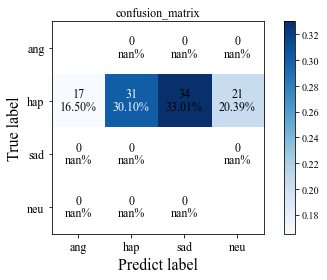

Epoch    10:
Training Loss 0.278; Training Acc 63.570%; Validation Acc 35.294%; Test Acc 34.951%


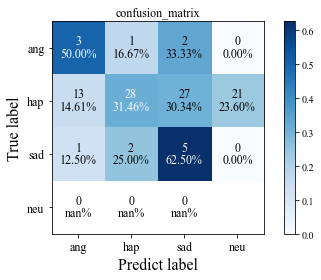

Epoch    20:
Training Loss 0.248; Training Acc 75.306%; Validation Acc 47.059%; Test Acc 40.777%


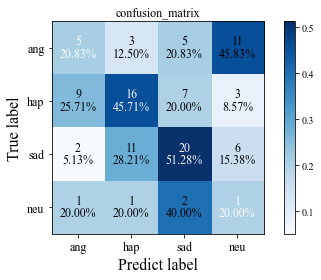

Epoch    30:
Training Loss 0.234; Training Acc 81.051%; Validation Acc 43.137%; Test Acc 45.631%


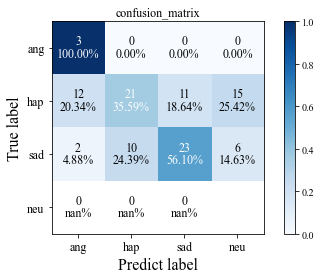

Epoch    40:
Training Loss 0.224; Training Acc 85.330%; Validation Acc 39.216%; Test Acc 37.864%


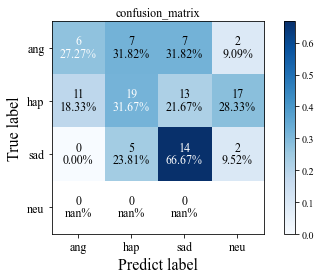

Epoch    50:
Training Loss 0.218; Training Acc 87.775%; Validation Acc 40.196%; Test Acc 45.631%


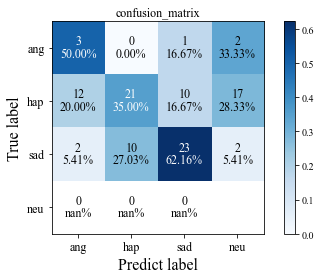

Epoch    60:
Training Loss 0.215; Training Acc 88.631%; Validation Acc 36.275%; Test Acc 41.748%


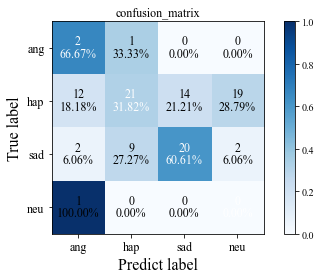

Epoch    70:
Training Loss 0.214; Training Acc 89.364%; Validation Acc 39.216%; Test Acc 40.777%


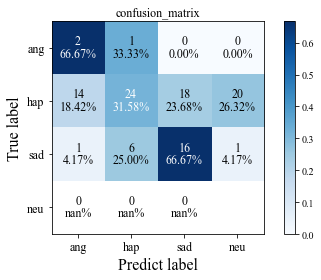

Epoch    80:
Training Loss 0.210; Training Acc 90.465%; Validation Acc 37.255%; Test Acc 36.893%


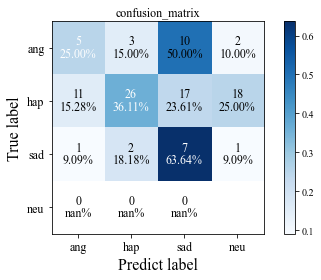

Epoch    90:
Training Loss 0.210; Training Acc 90.954%; Validation Acc 34.314%; Test Acc 33.981%


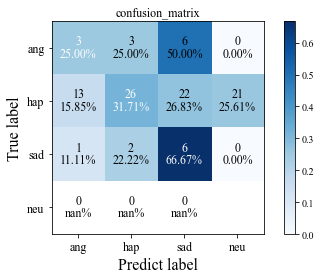

Epoch   100:
Training Loss 0.213; Training Acc 89.487%; Validation Acc 34.314%; Test Acc 33.010%


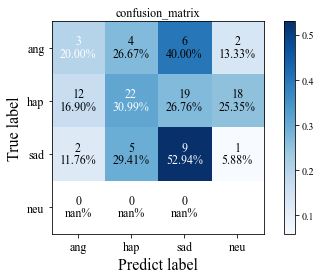

Epoch   110:
Training Loss 0.209; Training Acc 91.076%; Validation Acc 30.392%; Test Acc 28.155%


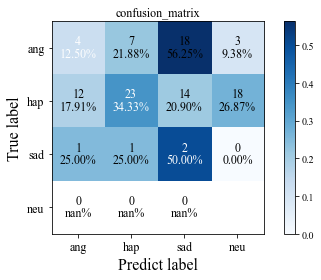

Epoch   120:
Training Loss 0.209; Training Acc 91.076%; Validation Acc 34.314%; Test Acc 33.010%


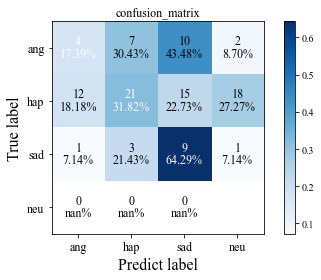

Epoch   130:
Training Loss 0.209; Training Acc 90.831%; Validation Acc 36.275%; Test Acc 37.864%


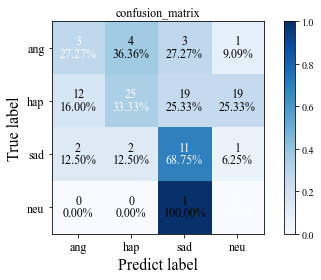

Epoch   140:
Training Loss 0.205; Training Acc 92.543%; Validation Acc 37.255%; Test Acc 32.039%


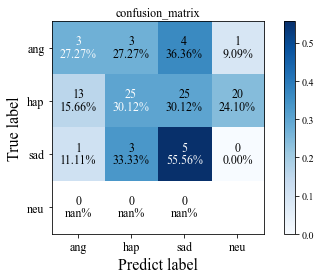

Epoch   150:
Training Loss 0.206; Training Acc 92.176%; Validation Acc 38.235%; Test Acc 34.951%


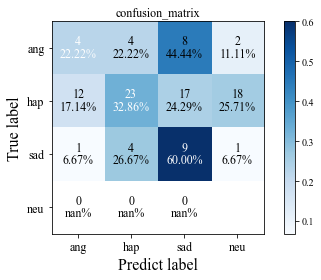

Epoch   160:
Training Loss 0.206; Training Acc 92.298%; Validation Acc 29.412%; Test Acc 29.126%


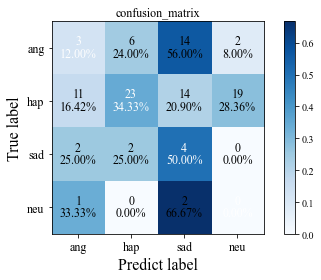

Epoch   170:
Training Loss 0.206; Training Acc 91.932%; Validation Acc 27.451%; Test Acc 33.010%


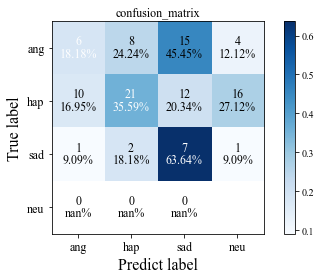

Epoch   180:
Training Loss 0.208; Training Acc 91.320%; Validation Acc 37.255%; Test Acc 35.922%


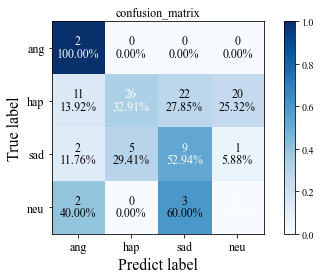

Epoch   190:
Training Loss 0.204; Training Acc 92.910%; Validation Acc 30.392%; Test Acc 31.068%


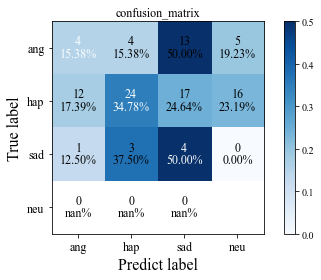

Epoch   200:
Training Loss 0.204; Training Acc 92.910%; Validation Acc 32.353%; Test Acc 33.010%


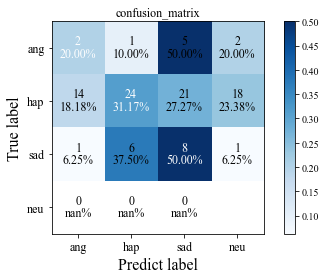

Epoch   210:
Training Loss 0.202; Training Acc 93.765%; Validation Acc 32.353%; Test Acc 34.951%


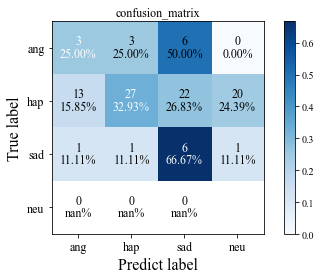

Epoch   220:
Training Loss 0.204; Training Acc 93.032%; Validation Acc 32.353%; Test Acc 33.010%


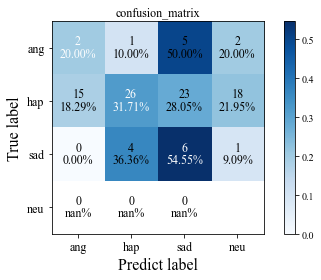

Epoch   230:
Training Loss 0.203; Training Acc 93.521%; Validation Acc 25.490%; Test Acc 31.068%


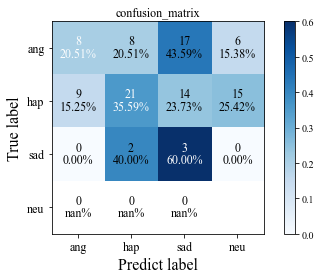

Epoch   240:
Training Loss 0.204; Training Acc 92.910%; Validation Acc 30.392%; Test Acc 34.951%


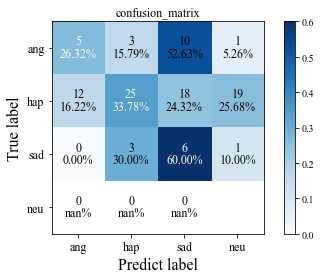

Epoch   250:
Training Loss 0.204; Training Acc 92.665%; Validation Acc 28.431%; Test Acc 35.922%


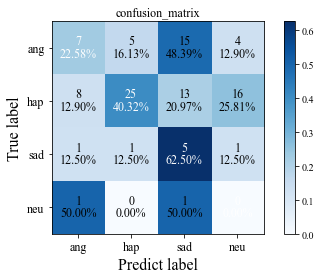

Epoch   260:
Training Loss 0.203; Training Acc 93.399%; Validation Acc 32.353%; Test Acc 31.068%


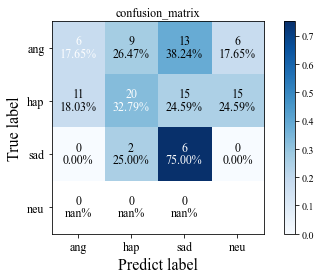

Epoch   270:
Training Loss 0.201; Training Acc 94.010%; Validation Acc 31.373%; Test Acc 27.184%


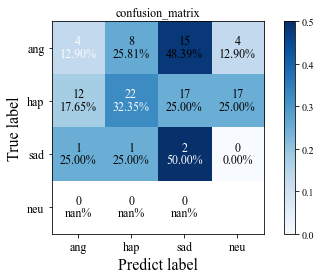

Epoch   280:
Training Loss 0.203; Training Acc 93.399%; Validation Acc 28.431%; Test Acc 25.243%


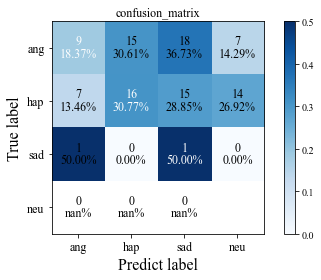

Epoch   290:
Training Loss 0.203; Training Acc 93.643%; Validation Acc 29.412%; Test Acc 26.214%


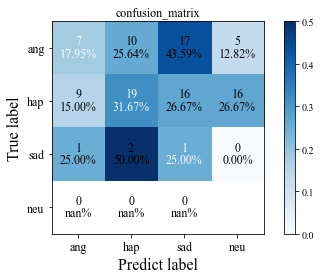

Epoch   300:
Training Loss 0.203; Training Acc 93.399%; Validation Acc 28.431%; Test Acc 38.835%


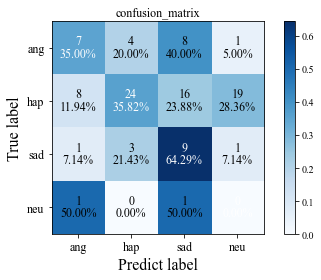

Epoch   310:
Training Loss 0.201; Training Acc 94.132%; Validation Acc 26.471%; Test Acc 34.951%


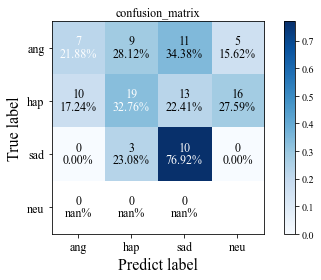

Epoch   320:
Training Loss 0.202; Training Acc 93.765%; Validation Acc 33.333%; Test Acc 32.039%


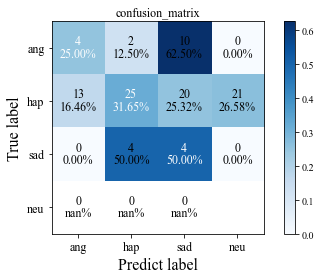

Epoch   330:
Training Loss 0.202; Training Acc 93.521%; Validation Acc 36.275%; Test Acc 38.835%


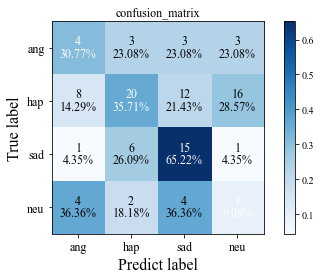

Epoch   340:
Training Loss 0.201; Training Acc 94.377%; Validation Acc 33.333%; Test Acc 33.010%


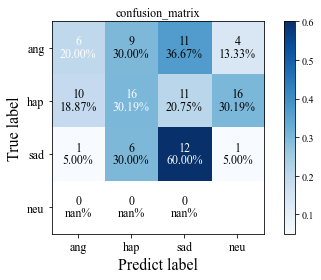

Epoch   350:
Training Loss 0.202; Training Acc 93.399%; Validation Acc 34.314%; Test Acc 39.806%


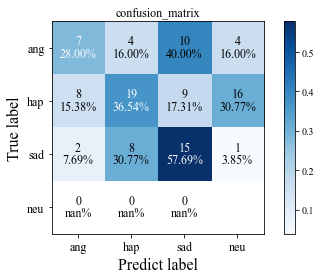

Epoch   360:
Training Loss 0.200; Training Acc 94.621%; Validation Acc 32.353%; Test Acc 37.864%


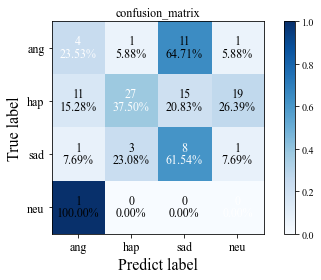

Epoch   370:
Training Loss 0.200; Training Acc 94.499%; Validation Acc 35.294%; Test Acc 37.864%


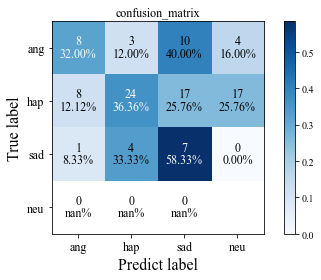

Epoch   380:
Training Loss 0.204; Training Acc 93.032%; Validation Acc 32.353%; Test Acc 39.806%


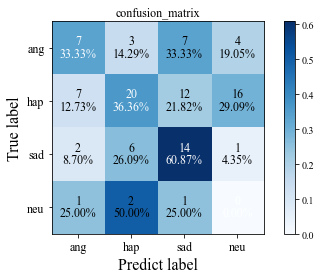

Epoch   390:
Training Loss 0.200; Training Acc 94.743%; Validation Acc 31.373%; Test Acc 28.155%


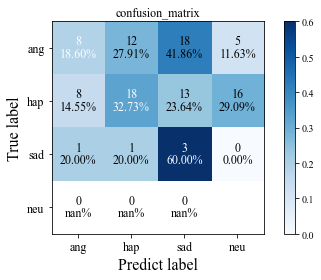

Epoch   400:
Training Loss 0.199; Training Acc 94.621%; Validation Acc 25.490%; Test Acc 23.301%


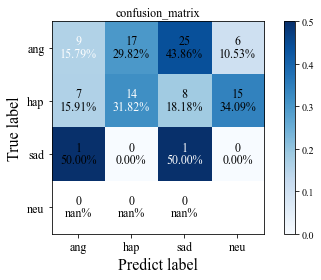

Epoch   410:
Training Loss 0.199; Training Acc 94.988%; Validation Acc 34.314%; Test Acc 31.068%


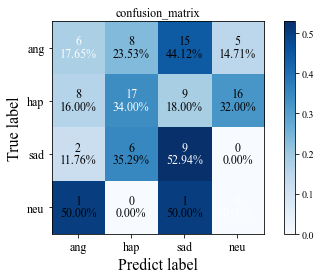

Epoch   420:
Training Loss 0.199; Training Acc 95.110%; Validation Acc 17.647%; Test Acc 24.272%


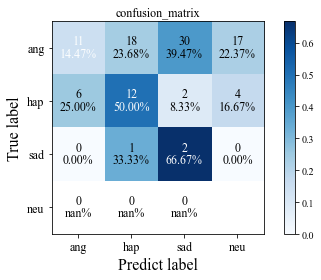

Epoch   430:
Training Loss 0.198; Training Acc 95.232%; Validation Acc 18.627%; Test Acc 23.301%


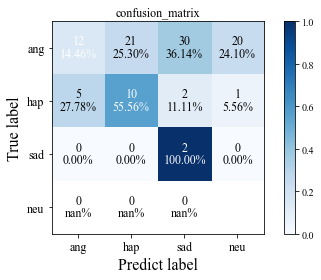

Epoch   440:
Training Loss 0.199; Training Acc 94.988%; Validation Acc 28.431%; Test Acc 35.922%


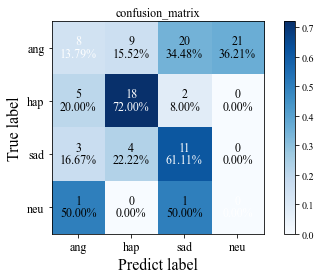

Epoch   450:
Training Loss 0.201; Training Acc 93.888%; Validation Acc 16.667%; Test Acc 20.388%


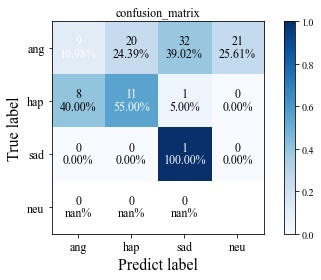

Epoch   460:
Training Loss 0.198; Training Acc 95.355%; Validation Acc 22.549%; Test Acc 24.272%


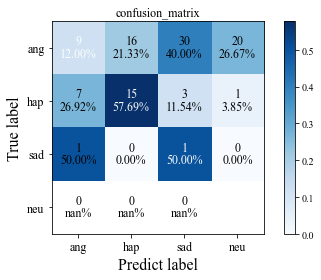

Epoch   470:
Training Loss 0.199; Training Acc 94.988%; Validation Acc 27.451%; Test Acc 36.893%


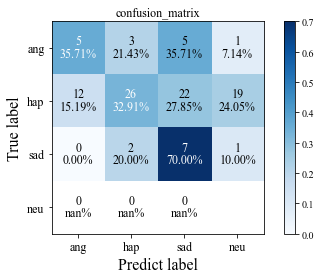

Epoch   480:
Training Loss 0.199; Training Acc 95.110%; Validation Acc 36.275%; Test Acc 41.748%


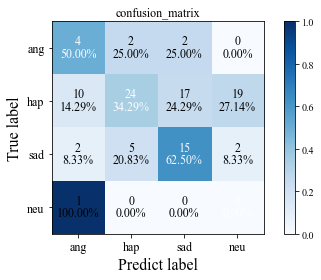

Epoch   490:
Training Loss 0.198; Training Acc 95.355%; Validation Acc 27.451%; Test Acc 28.155%


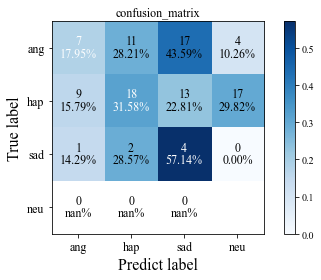

Epoch   500:
Training Loss 0.199; Training Acc 94.988%; Validation Acc 28.431%; Test Acc 32.039%


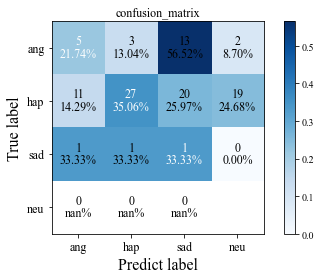

Epoch   510:
Training Loss 0.201; Training Acc 94.132%; Validation Acc 29.412%; Test Acc 34.951%


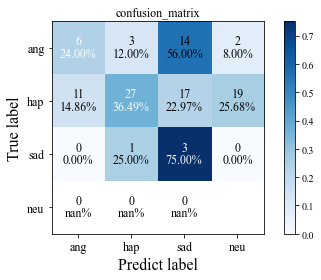

Epoch   520:
Training Loss 0.197; Training Acc 95.599%; Validation Acc 29.412%; Test Acc 25.243%


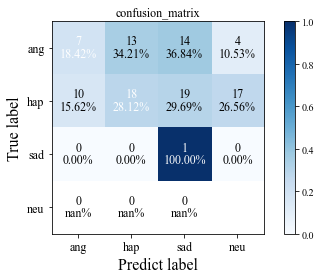

Epoch   530:
Training Loss 0.198; Training Acc 95.477%; Validation Acc 29.412%; Test Acc 29.126%


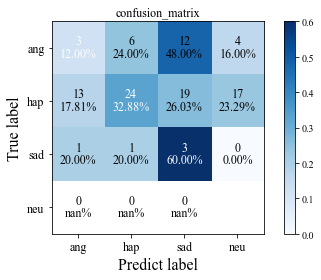

Epoch   540:
Training Loss 0.197; Training Acc 95.721%; Validation Acc 29.412%; Test Acc 33.981%


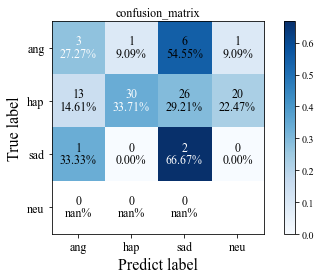

Epoch   550:
Training Loss 0.198; Training Acc 95.232%; Validation Acc 32.353%; Test Acc 34.951%


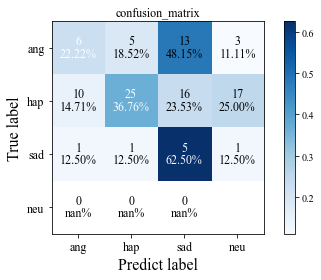

Epoch   560:
Training Loss 0.197; Training Acc 95.721%; Validation Acc 29.412%; Test Acc 37.864%


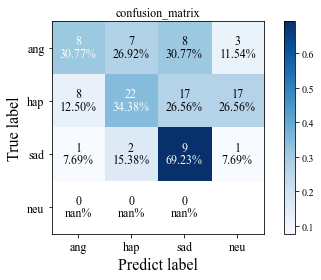

Epoch   570:
Training Loss 0.200; Training Acc 94.254%; Validation Acc 33.333%; Test Acc 35.922%


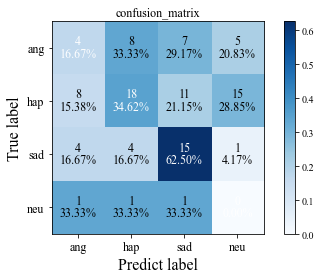

Epoch   580:
Training Loss 0.197; Training Acc 95.721%; Validation Acc 29.412%; Test Acc 33.010%


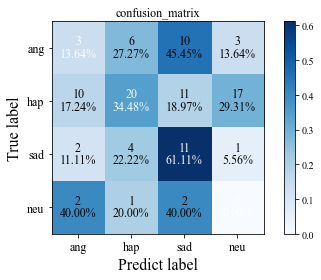

Epoch   590:
Training Loss 0.201; Training Acc 94.010%; Validation Acc 33.333%; Test Acc 35.922%


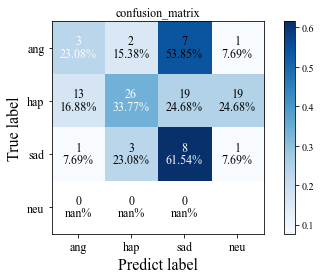

Epoch   600:
Training Loss 0.197; Training Acc 95.721%; Validation Acc 33.333%; Test Acc 40.777%


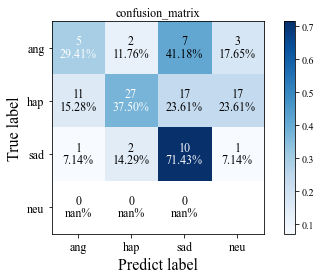

Epoch   610:
Training Loss 0.197; Training Acc 95.721%; Validation Acc 34.314%; Test Acc 37.864%


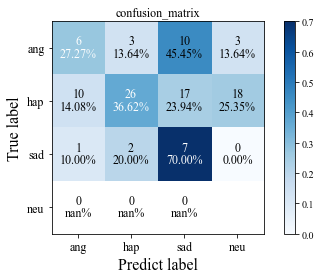

Epoch   620:
Training Loss 0.197; Training Acc 95.721%; Validation Acc 30.392%; Test Acc 34.951%


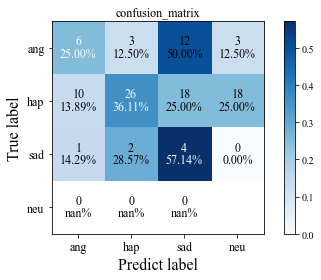

Epoch   630:
Training Loss 0.199; Training Acc 95.110%; Validation Acc 38.235%; Test Acc 37.864%


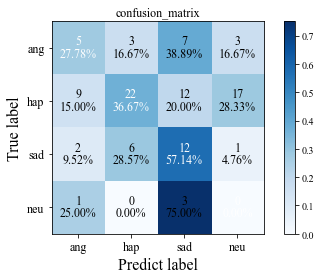

Epoch   640:
Training Loss 0.197; Training Acc 95.721%; Validation Acc 36.275%; Test Acc 35.922%


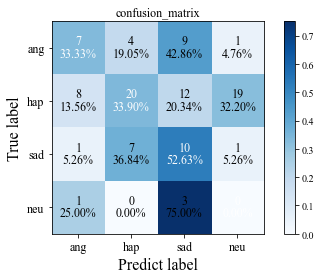

Epoch   650:
Training Loss 0.198; Training Acc 95.477%; Validation Acc 33.333%; Test Acc 34.951%


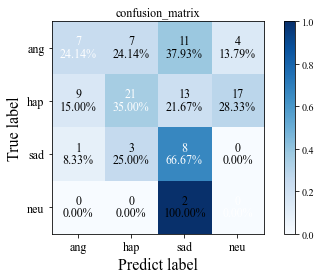

Epoch   660:
Training Loss 0.197; Training Acc 95.599%; Validation Acc 30.392%; Test Acc 34.951%


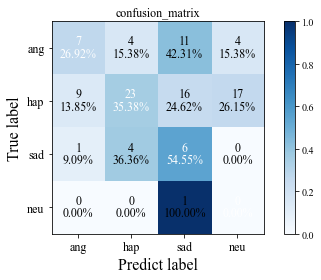

Epoch   670:
Training Loss 0.199; Training Acc 95.110%; Validation Acc 31.373%; Test Acc 33.010%


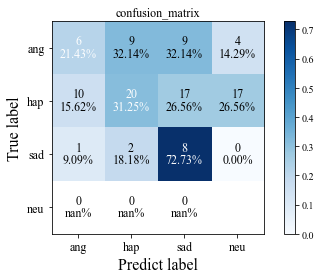

Epoch   680:
Training Loss 0.198; Training Acc 95.477%; Validation Acc 39.216%; Test Acc 39.806%


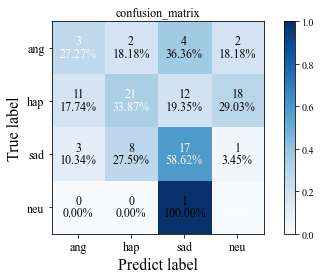

Epoch   690:
Training Loss 0.199; Training Acc 95.110%; Validation Acc 32.353%; Test Acc 31.068%


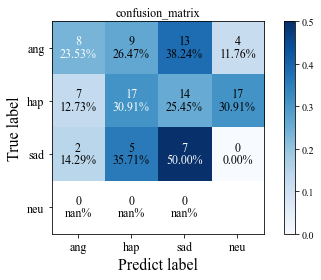

Epoch   700:
Training Loss 0.198; Training Acc 95.477%; Validation Acc 35.294%; Test Acc 42.718%


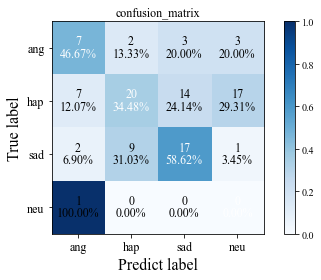

Epoch   710:
Training Loss 0.197; Training Acc 95.721%; Validation Acc 35.294%; Test Acc 35.922%


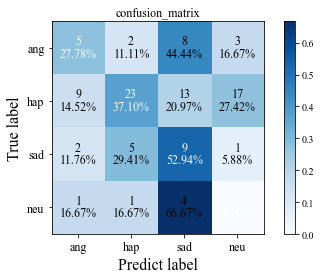

Epoch   720:
Training Loss 0.197; Training Acc 95.599%; Validation Acc 34.314%; Test Acc 34.951%


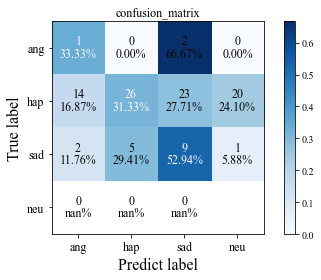

Epoch   730:
Training Loss 0.197; Training Acc 95.599%; Validation Acc 41.176%; Test Acc 46.602%


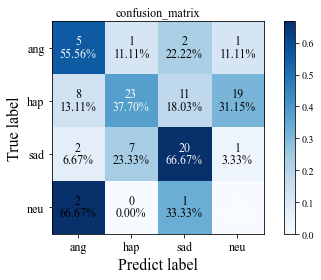

Epoch   740:
Training Loss 0.197; Training Acc 95.599%; Validation Acc 42.157%; Test Acc 38.835%


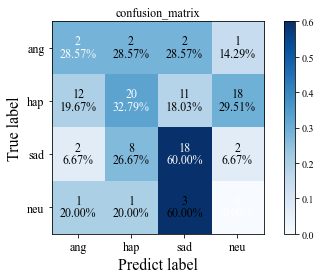

Epoch   750:
Training Loss 0.197; Training Acc 95.721%; Validation Acc 39.216%; Test Acc 35.922%


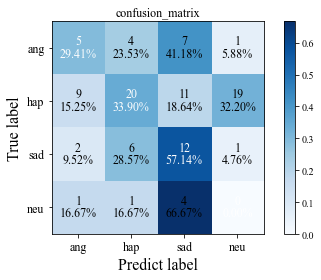

Epoch   760:
Training Loss 0.197; Training Acc 95.599%; Validation Acc 30.392%; Test Acc 30.097%


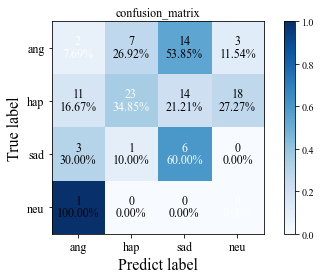

Epoch   770:
Training Loss 0.197; Training Acc 95.844%; Validation Acc 31.373%; Test Acc 33.010%


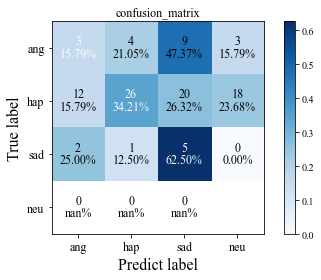

Epoch   780:
Training Loss 0.198; Training Acc 95.355%; Validation Acc 30.392%; Test Acc 31.068%


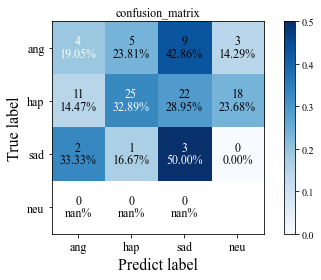

Epoch   790:
Training Loss 0.198; Training Acc 95.355%; Validation Acc 38.235%; Test Acc 36.893%


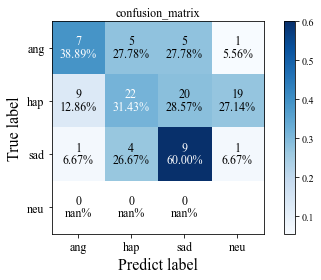

Epoch   800:
Training Loss 0.197; Training Acc 95.599%; Validation Acc 27.451%; Test Acc 34.951%


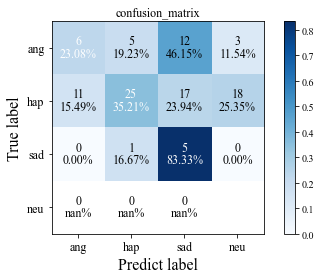

Epoch   810:
Training Loss 0.199; Training Acc 94.866%; Validation Acc 34.314%; Test Acc 35.922%


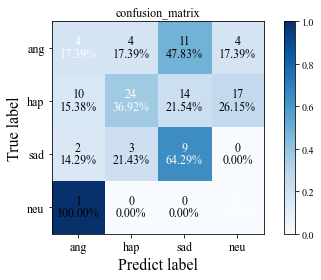

Epoch   820:
Training Loss 0.198; Training Acc 95.477%; Validation Acc 36.275%; Test Acc 39.806%


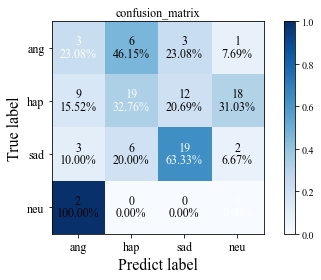

Epoch   830:
Training Loss 0.197; Training Acc 95.721%; Validation Acc 41.176%; Test Acc 42.718%


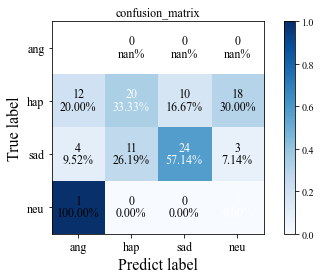

Epoch   840:
Training Loss 0.197; Training Acc 95.721%; Validation Acc 39.216%; Test Acc 39.806%


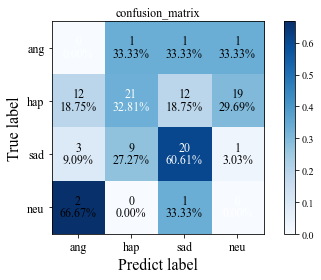

Epoch   850:
Training Loss 0.199; Training Acc 95.110%; Validation Acc 37.255%; Test Acc 38.835%


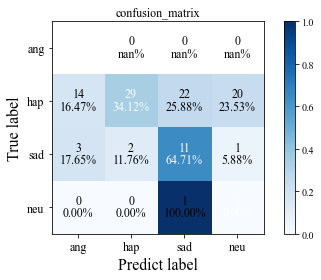

Epoch   860:
Training Loss 0.197; Training Acc 95.721%; Validation Acc 36.275%; Test Acc 36.893%


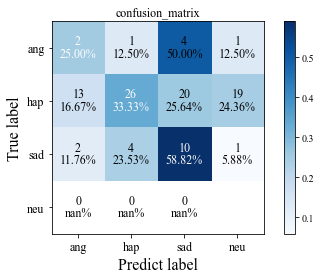

Epoch   870:
Training Loss 0.197; Training Acc 95.721%; Validation Acc 37.255%; Test Acc 36.893%


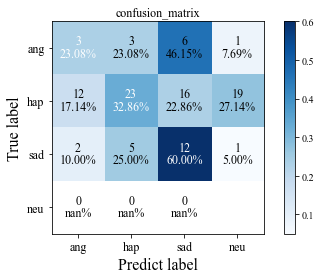

Epoch   880:
Training Loss 0.198; Training Acc 95.355%; Validation Acc 37.255%; Test Acc 35.922%


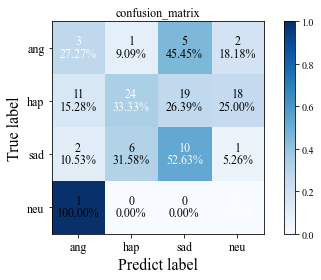

Epoch   890:
Training Loss 0.197; Training Acc 95.721%; Validation Acc 38.235%; Test Acc 40.777%


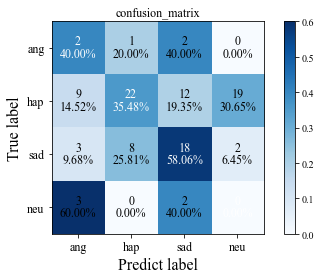

Epoch   900:
Training Loss 0.198; Training Acc 95.477%; Validation Acc 36.275%; Test Acc 41.748%


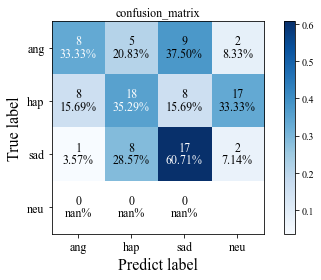

Epoch   910:
Training Loss 0.197; Training Acc 95.721%; Validation Acc 33.333%; Test Acc 35.922%


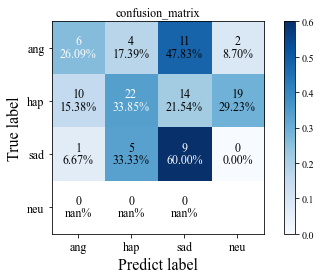

Epoch   920:
Training Loss 0.197; Training Acc 95.844%; Validation Acc 39.216%; Test Acc 35.922%


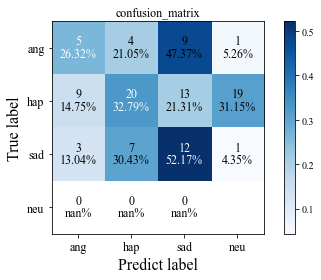

Epoch   930:
Training Loss 0.200; Training Acc 94.377%; Validation Acc 29.412%; Test Acc 33.010%


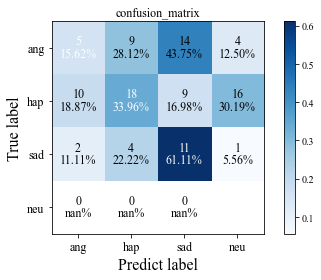

Epoch   940:
Training Loss 0.197; Training Acc 95.844%; Validation Acc 39.216%; Test Acc 41.748%


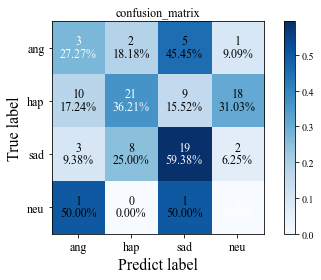

Epoch   950:
Training Loss 0.197; Training Acc 95.844%; Validation Acc 39.216%; Test Acc 40.777%


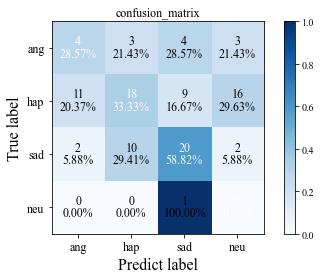

Epoch   960:
Training Loss 0.197; Training Acc 95.844%; Validation Acc 39.216%; Test Acc 38.835%


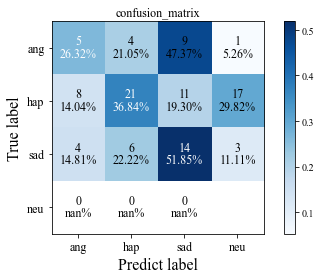

Epoch   970:
Training Loss 0.196; Training Acc 95.966%; Validation Acc 34.314%; Test Acc 36.893%


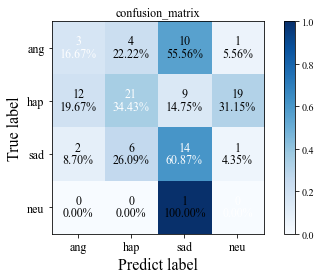

Epoch   980:
Training Loss 0.196; Training Acc 95.966%; Validation Acc 34.314%; Test Acc 37.864%


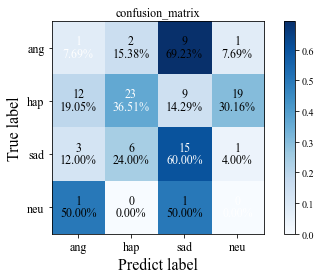

Epoch   990:
Training Loss 0.199; Training Acc 94.988%; Validation Acc 31.373%; Test Acc 33.010%


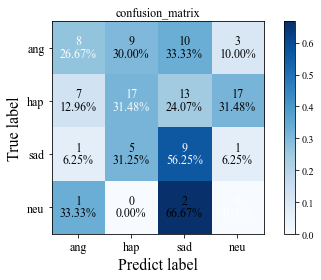

Epoch  1000:
Training Loss 0.197; Training Acc 95.721%; Validation Acc 30.392%; Test Acc 36.893%


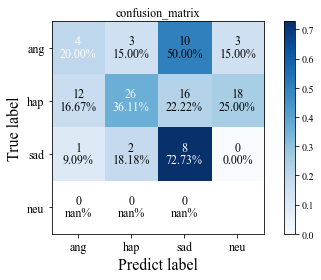

Finished training


In [25]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.00001)
criterion = nn.CrossEntropyLoss()

epochs = 500

for epoch in range(1, epochs+1):
    cm=[[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]
    train_loss = 0.0
    val_loss = 0.0
    train_acc = 0.0
    val_acc = 0.0
    test_acc = 0.0
    for batch, (inputs,targets) in enumerate(train_loader, 0):
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        preds = torch.max(outputs, 1)[1]
        classes = torch.max(targets, 1)[1]
        train_correct = (preds == classes).sum()
        train_acc += train_correct.item()
        train_loss += loss.item()
    if epoch % 10 == 0 or epoch == 1:
        with torch.no_grad():
            net.eval()
            for inputs,targets in val_loader:
                outputs = net(inputs)
                preds = torch.max(outputs, 1)[1]
                classes = torch.max(targets, 1)[1]
                val_correct = (preds == classes).sum()
                val_acc += val_correct.item()
                loss = criterion(outputs, targets)
                val_loss += loss.item()
            for inputs,targets in test_loader:
                outputs = net(inputs)
                preds = torch.max(outputs, 1)[1]
                classes = torch.max(targets, 1)[1]
                cm=conf_mat(cm,Tlabels(classes.numpy()),Plabels(preds.numpy()))
                test_correct = (preds == classes).sum()
                test_acc += test_correct.item()
            net.train()
        Train_loss = train_loss/(len(train_set))
        Train_acc = 100*train_acc/(len(train_set))
        Val_acc = 100*val_acc/(len(val_set))
        Test_acc = 100*test_acc/(len(test_set))
        print(f'Epoch {epoch:5d}:')
        print(f'Training Loss {Train_loss:.3f}; Training Acc {Train_acc:.3f}%; Validation Acc {Val_acc:.3f}%; Test Acc {Test_acc:.3f}%')
        cmplot(cm)
print('Finished training')

# after training, choose epoch based on validation accuracy
# to do:
# plot the loss/accuracy
# get confusion matrix
